## Imports

In [1]:
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_query import PWEQuery
from PW_explorer.Custom_Visualization_Functions import euler_visualization_nxpd
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import itertools

In [2]:
import PW_explorer as pwe

## Some Visualization Code

In [3]:
# This actually already exits in PW-E but it has a small bug which should be fixed soon.
from sklearn.cluster import DBSCAN
def dbscan_clustering(dist_matrix, save_to_file=None):

    fig, ax = plt.subplots()

    db = DBSCAN(metric='precomputed', eps=0.5, min_samples=1)
    labels = db.fit_predict(dist_matrix)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) #- (1 if -1 in labels else 0)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    #x_2d = PCA(n_components = 2).fit_transform(dist_matrix)

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        xy = dist_matrix[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = dist_matrix[class_member_mask & ~core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    ax.set_title('Estimated number of clusters: %d' % n_clusters_)
    if save_to_file is not None:
        fig.savefig(save_to_file)
    return fig, labels

In [4]:
# This actually already exits in PW-E but it has a small bug which should be fixed soon.
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
def linkage_dendrogram(dist_matrix, save_to_folder=None):

    X = squareform(dist_matrix)
    dendrogram_size = (max(25, int(np.sqrt(2 * len(X)) / 10)), 10)
    figs = []
    for dist_type in ['single', 'complete', 'average', 'weighted']:
        fig, ax = plt.subplots(figsize=dendrogram_size)
        linkage_matrix = linkage(X, dist_type)
        dendrogram(linkage_matrix, labels=[str(i) for i in range(len(dist_matrix))], show_leaf_counts=True, ax=ax)
        ax.set_title("Dendrogram ({})".format(dist_type))
        if save_to_folder is not None:
            fig.savefig(os.path.join(save_to_folder, '{}_dendrogram.png'.format(dist_type)))
        figs.append(fig)
    return figs

In [5]:
# Four Colorability Visualization Code
#!/usr/bin/env python3

from sklearn.cluster import DBSCAN
from PW_explorer.pwe_helper import rel_id_from_rel_name, mkdir_p
import matplotlib.pyplot as plt
from collections import defaultdict
import os


def get_colors_list(df, id):
    idx = list(map(int, list(df[df.pw == id].x1)))
    clrs = list(df[df.pw == id].x2)

    ordered_clrs = [x for _, x in sorted(zip(idx, clrs))]
    return ordered_clrs


def four_col_visualize(**kwargs):

    kwargs = defaultdict(lambda: None, kwargs)
    dfs = kwargs['dfs']
    relations = kwargs['relations']
    save_to_folder = kwargs['save_to_folder']
    dist_matrix = kwargs['dist_matrix']

    if relations is None or dfs is None:
        print("No objects passed.")
        exit(1)

    db = DBSCAN(metric='precomputed', eps=0.5, min_samples=1)
    labels = db.fit_predict(dist_matrix)

    unique_indices = {}
    label_counts = {}
    for i, label in enumerate(labels):
        if label not in unique_indices:
            unique_indices[label] = i
            label_counts[label] = 1
        else:
            label_counts[label] += 1

    df = dfs[rel_id_from_rel_name('col_2', relations)]

    figs = []
    for label, idx in list(unique_indices.items()):
        fig, ax = plt.subplots()
        cols = get_colors_list(df, idx + 1)
        # print(cols)
        group_size = [1 for _ in cols]
        ax.pie(group_size, colors=cols)
        my_circle = plt.Circle((0, 0), 0.7, color='white')
        p = plt.gcf()
        p.gca().add_artist(my_circle)
        ax.annotate(str(label_counts[label]), xy=(0, 0), ha='center', va='center', fontsize=35)
        figs.append(fig)

    if save_to_folder is not None:
        output_folder = os.path.join(save_to_folder, 'four_colorability_visualization')
        mkdir_p(output_folder)
        for i, fig in enumerate(figs):
            fig.savefig(os.path.join(output_folder, 'pattern_{}.png'.format(str(i))))

    return figs


## N-queens (n=8)
#### Clustering Equivalent (symmetric) solutions

In [6]:
n = 8

In [7]:
nqueens_clingo_rules = [
    '#const n = {}.'.format(n),
    '% domain',
    'number(1..n).',
    '% alldifferent',
    '1 { q(X,Y) : number(Y) } 1 :- number(X).',
    '1 { q(X,Y) : number(X) } 1 :- number(Y).',
    '% remove conflicting answers',
    ':- number(X1;X2;Y1;Y2), q(X1,Y1), q(X2,Y2), X1 < X2, Y1 == Y2.',
    ':- number(X1;X2;Y1;Y2), q(X1,Y1), q(X2,Y2), X1 < X2, Y1 + X1 == Y2 + X2.',
    ':- number(X1;X2;Y1;Y2), q(X1,Y1), q(X2,Y2), X1 < X2, Y1 - X1 == Y2 - X2.',
    '#show q/2.',
]

In [8]:
nqueens_clingo_soln = run_clingo(clingo_rules=nqueens_clingo_rules)
print('\n'.join(nqueens_clingo_soln))

Answer: 1
q(4,1) q(6,2) q(8,3) q(2,4) q(7,5) q(1,6) q(3,7) q(5,8)
Answer: 2
q(3,1) q(5,2) q(2,3) q(8,4) q(1,5) q(7,6) q(4,7) q(6,8)
Answer: 3
q(5,1) q(3,2) q(1,3) q(7,4) q(2,5) q(8,6) q(6,7) q(4,8)
Answer: 4
q(6,1) q(4,2) q(7,3) q(1,4) q(8,5) q(2,6) q(5,7) q(3,8)
Answer: 5
q(5,1) q(3,2) q(1,3) q(6,4) q(8,5) q(2,6) q(4,7) q(7,8)
Answer: 6
q(4,1) q(6,2) q(8,3) q(3,4) q(1,5) q(7,6) q(5,7) q(2,8)
Answer: 7
q(5,1) q(7,2) q(1,3) q(3,4) q(8,5) q(6,6) q(4,7) q(2,8)
Answer: 8
q(8,1) q(3,2) q(1,3) q(6,4) q(2,5) q(5,6) q(7,7) q(4,8)
Answer: 9
q(4,1) q(7,2) q(3,3) q(8,4) q(2,5) q(5,6) q(1,7) q(6,8)
Answer: 10
q(6,1) q(3,2) q(7,3) q(2,4) q(8,5) q(5,6) q(1,7) q(4,8)
Answer: 11
q(7,1) q(3,2) q(1,3) q(6,4) q(8,5) q(5,6) q(2,7) q(4,8)
Answer: 12
q(2,1) q(7,2) q(3,3) q(6,4) q(8,5) q(5,6) q(1,7) q(4,8)
Answer: 13
q(2,1) q(6,2) q(8,3) q(3,4) q(1,5) q(4,6) q(7,7) q(5,8)
Answer: 14
q(1,1) q(6,2) q(8,3) q(3,4) q(7,5) q(4,6) q(2,7) q(5,8)
Answer: 15
q(3,1) q(6,2) q(2,3) q(7,4) q(1,5) q(4,6) q(8,7) q(5,8)
Answ

In [9]:
dfs, rels, pws = load_worlds(clingo_output=nqueens_clingo_soln, preprocessed=False, reasoner='clingo')

Number of Models: 92


In [10]:
list(map(lambda x: x.__dict__, rels))

[{'relation_name': 'q_2', 'arity': 2, 'r_id': 0}]

In [11]:
def get_board_from_df(df):
    board = np.zeros((len(df), len(df)))
    for i, row in df.iterrows():
        x = int(row['x1']) - 1
        y = int(row['x2']) - 1
        board[x,y] = 1
    return board

import matplotlib.pyplot as plt
from matplotlib import colors
def visualize_nqueens_solution(dfs, pw_id):
    df = dfs[0]
    df = df[df['pw'] == pw_id]
    board = get_board_from_df(df)
    ax = plt.matshow(board)
    return ax

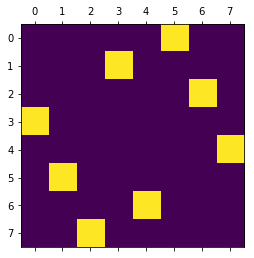

In [12]:
_ = visualize_nqueens_solution(dfs, 1)

In [13]:
# Can make it more continuous to be able to tell which solutions are actually similar
def nqueens_distance(dfs, pw_id_1, pw_id_2):
    df = dfs[0]
    pw1 = df[df['pw'] == pw_id_1]
    pw2 = df[df['pw'] == pw_id_2]
    board1 = get_board_from_df(pw1)
    board2 = get_board_from_df(pw2)
    
    are_same = False

    temp0 = board1
    temp1 = np.flip(temp0, 0)
    temp2 = np.flip(temp0, 1)
    
    if (temp0 == board2).all() or (temp1 == board2).all() or (temp2 == board2).all():
        return 0
    
    temp0 = np.rot90(board1, k=1)
    temp1 = np.flip(temp0, 0)
    temp2 = np.flip(temp0, 1)
    
    if (temp0 == board2).all() or (temp1 == board2).all() or (temp2 == board2).all():
        return 0
    
    temp0 = np.rot90(board1, k=2)
    temp1 = np.flip(temp0, 0)
    temp2 = np.flip(temp0, 1)
    
    if (temp0 == board2).all() or (temp1 == board2).all() or (temp2 == board2).all():
        return 0
    
    temp0 = np.rot90(board1, k=-1) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.rot90.html
    temp1 = np.flip(temp0, 0) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.flip.html
    temp2 = np.flip(temp0, 1)
    
    if (temp0 == board2).all() or (temp1 == board2).all() or (temp2 == board2).all():
        return 0
    
    return 1

In [14]:
dist_matrix = np.zeros((len(pws), len(pws)))
for i in range(1, len(pws)+1):
    for j in range(i+1, len(pws)+1):
        dist_matrix[i-1][j-1] = dist_matrix[j-1][i-1] = nqueens_distance(dfs, i, j)

array([ 0,  0,  0,  0,  1,  1,  2,  3,  2,  1,  4,  5,  4,  3,  1,  5,  2,
        2,  6,  1,  3,  4,  5,  6,  7,  7,  2,  7,  6,  6,  7,  5,  4,  3,
        2,  5,  1,  3,  4,  3,  5,  4,  1,  2,  6,  7,  6,  7,  7,  6,  4,
        5,  3,  6,  7,  2,  5,  3,  4,  1,  8,  9, 10,  9, 11, 10, 11,  8,
       10, 11, 10, 11,  9,  8,  8,  9, 10, 11,  9,  8,  9, 10, 11,  8, 10,
       11,  8,  9, 11,  8, 10,  9])

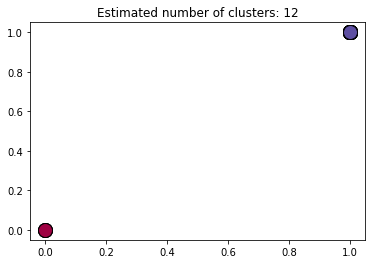

In [17]:
dbscan_fig, dbscan_labels = pwe.visualize.dbscan_clustering(dist_matrix, None)
dbscan_labels

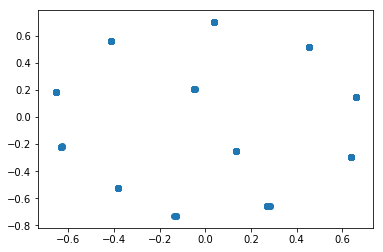

In [16]:
sklearn_mds_g = pwe.visualize.mds_sklearn(A=dist_matrix)

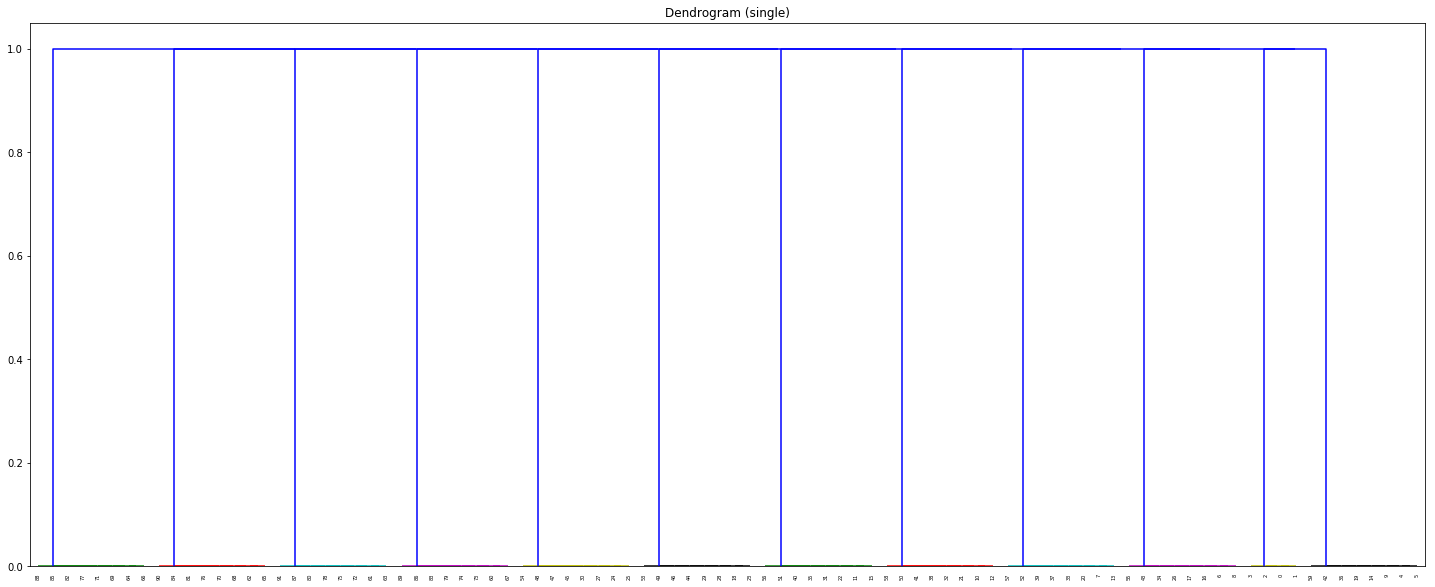

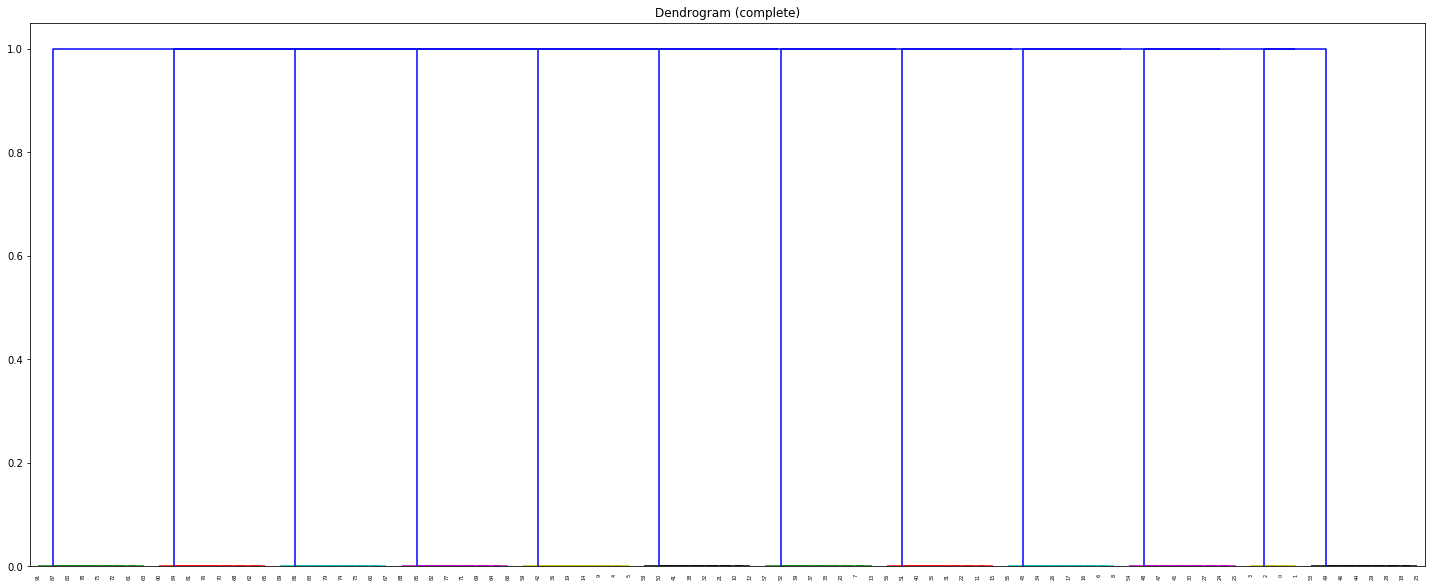

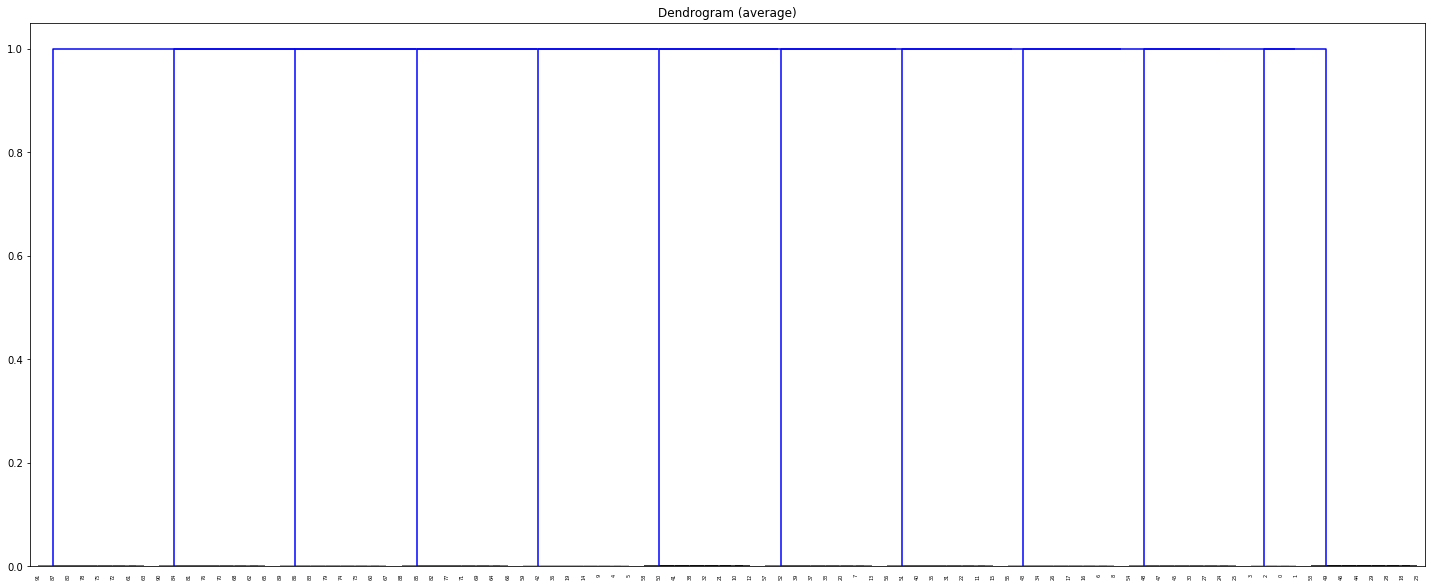

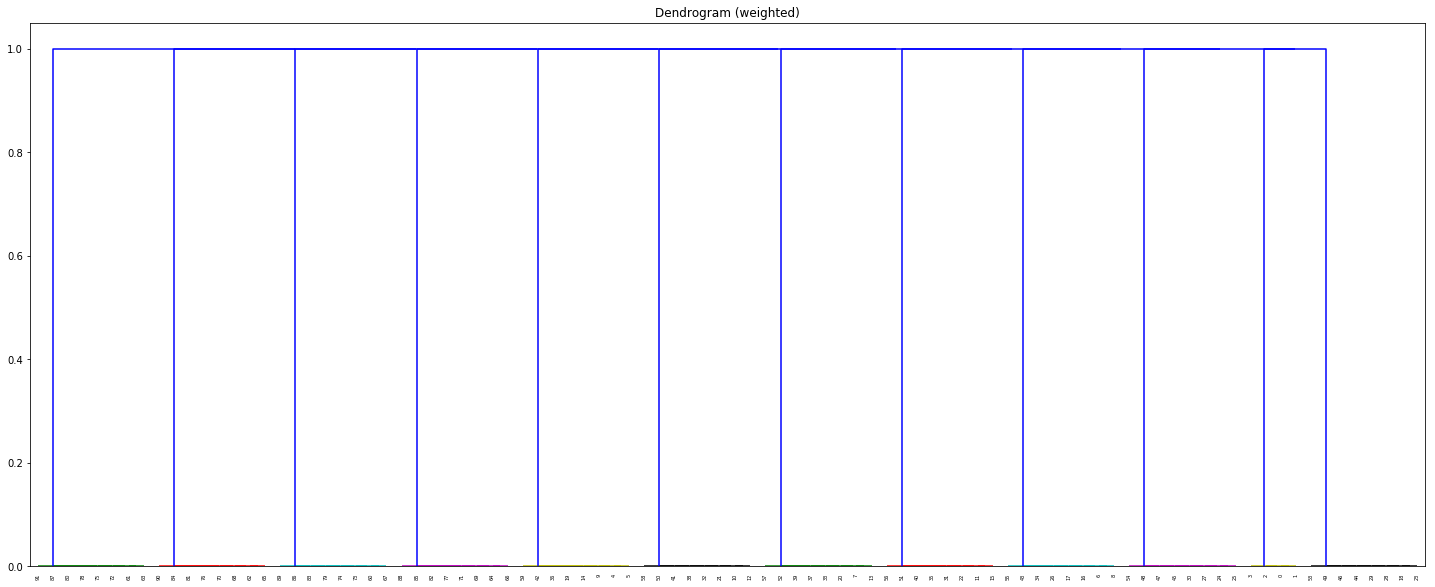

In [18]:
dendrograms = pwe.visualize.linkage_dendrogram(dist_matrix=dist_matrix, save_to_folder=None)

## 4-colorability of Rings
#### Clustering Equivalent Solutions

In [19]:
ring_size = 4

In [20]:
four_col_rules = [
    '% PROBLEM', 
    '% Color a circuit of n vertices with 4 colors, such that neighbors have different colors',
    '% To obtain all solutions: $ clingo circuit.lp4 -n0 ',

    '% PWs depending on n = 2,3,4,5,6,... is 12,24,84,240,732, ...',
    '% See also: ',
    '% * https://oeis.org/A226493 => Closed walks of length n in K_4 graph.',
    '% * https://oeis.org/A218034 => Number of ways to seat 4 types of people in n labeled seats around a',
    '%   circle such that no two adjacent people are of the same type.',
    '% * 4CT context: [steinberger2009unavoidable] considers circuit ',

    '% Number n of vertices v(X) of the circuit',
    '% Override default e.g. with 7: $ clingo circuit.lp4 -n0 -c n=7',
    '#const n = {}.'.format(ring_size),
    'v(1..n).',

    '% The neighborhood relation is a circuit:',
    'n(I,I+1) :- v(I), I < n. % Build a chain .. ',
    'n(n,1).                  % .. and close the circuit',
    'n(Y,X) :- n(X,Y).        % symmetric closure of n/2 (not really needed here)',

    '% Let there be 4 colors (no need to make this a parameter)',
    'colors(r;g;b;y).',

    '% Assign exactly one color to each vertice: ',
    '1 {col(X, C) : colors(C) } 1 :- v(X). ',

    '% Two neighbors X and Y cannot have the same color:',
    ':- col(X, C), col(Y, C), n(X,Y).',


    '#show col/2.',
    '%#show C: v(X),col(X,C).',
]

In [21]:
four_col_clingo_soln = run_clingo(clingo_rules=four_col_rules)
print('\n'.join(four_col_clingo_soln))

Answer: 1
col(4,g) col(1,b) col(2,g) col(3,r)
Answer: 2
col(4,g) col(1,y) col(2,g) col(3,r)
Answer: 3
col(4,b) col(1,y) col(2,g) col(3,r)
Answer: 4
col(1,b) col(4,y) col(2,g) col(3,r)
Answer: 5
col(1,g) col(4,y) col(2,b) col(3,r)
Answer: 6
col(4,g) col(1,y) col(2,b) col(3,r)
Answer: 7
col(1,g) col(4,b) col(2,b) col(3,r)
Answer: 8
col(4,b) col(1,y) col(2,b) col(3,r)
Answer: 9
col(4,g) col(1,b) col(2,y) col(3,r)
Answer: 10
col(1,g) col(4,y) col(2,y) col(3,r)
Answer: 11
col(1,b) col(4,y) col(2,y) col(3,r)
Answer: 12
col(1,g) col(4,b) col(2,y) col(3,r)
Answer: 13
col(4,r) col(1,g) col(2,r) col(3,g)
Answer: 14
col(1,g) col(4,b) col(2,r) col(3,g)
Answer: 15
col(1,g) col(4,y) col(2,r) col(3,g)
Answer: 16
col(4,r) col(1,g) col(2,y) col(3,g)
Answer: 17
col(1,g) col(4,y) col(2,y) col(3,g)
Answer: 18
col(1,g) col(4,b) col(2,y) col(3,g)
Answer: 19
col(4,r) col(1,y) col(2,r) col(3,g)
Answer: 20
col(4,b) col(1,y) col(2,r) col(3,g)
Answer: 21
col(4,r) col(1,g) col(2,b) col(3,g)
Answer: 22
col(4,r) co

In [22]:
dfs, rels, pws = load_worlds(clingo_output=four_col_clingo_soln, preprocessed=False, reasoner='clingo')

Number of Models: 84


In [23]:
list(map(lambda x: x.__dict__, rels))

[{'relation_name': 'col_2', 'arity': 2, 'r_id': 0}]

In [127]:
from PW_explorer.pwe_helper import rel_id_from_rel_name
import copy
from collections import defaultdict
def get_colors_list(df, id):
    idx = list(map(int, list(df[df.pw == id].x1)))
    clrs = list(df[df.pw == id].x2)

    ordered_clrs = [x for _, x in sorted(zip(idx, clrs))]
    return ordered_clrs


# get the underlying pattern in the form of a list of ints
def get_pattern(sequence):
    pattern = []
    pattern_dict = {}
    count_unique = 0

    for element in sequence:

        if element in pattern_dict:
            pattern.append(pattern_dict[element])
        else:
            pattern.append(count_unique)
            pattern_dict[element] = count_unique
            count_unique += 1

    return pattern, count_unique


def compare_patterns(p1, p2, check_cyclical_equivalence=True):
    if len(p1) != len(p2):
        return False

    if p1 == p2:
        return True

    if not check_cyclical_equivalence:
        return False

    n = len(p2)
    t2 = copy.copy(p2)

    for i in range(n - 1):
        temp = t2.pop()
        t2.insert(0, temp)
        new_pattern, _ = get_pattern(t2)
        if new_pattern == p1:
            return True

    return False


def four_col_dist_helper(s1, s2):
    pattern_s1, unique_s1 = get_pattern(s1)
    pattern_s2, unique_s2 = get_pattern(s2)

    # print s1, s2

    if unique_s1 != unique_s2:
        return 1

    #dist_ = 0 if compare_patterns(pattern_s1, pattern_s2) else 1
    # print dist_

    return abs(unique_s1 - unique_s2)#dist_


def four_col_dist(pw_id_1, pw_id_2, **kwargs):

    kwargs = defaultdict(lambda: None, kwargs)
    dfs = kwargs['dfs']
    relations = kwargs['relations']
    if dfs is None or relations is None:
        print("None objects passed in.")
        return -1

    if pw_id_1 == pw_id_2:
        return 0

    col_rel_id = rel_id_from_rel_name('col_2', relations)
    df = dfs[col_rel_id]

    s1 = get_colors_list(df, pw_id_1)
    s2 = get_colors_list(df, pw_id_2)

    return four_col_dist_helper(s1, s2)

In [128]:
dist_matrix = np.zeros((len(pws), len(pws)))
for i in range(1, len(pws)+1):
    for j in range(i+1, len(pws)+1):
        dist_matrix[i-1][j-1] = dist_matrix[j-1][i-1] = four_col_dist(i, j, dfs=dfs, relations=rels)

In [129]:
dist_matrix

array([[0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 0., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.]])

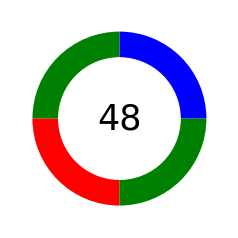

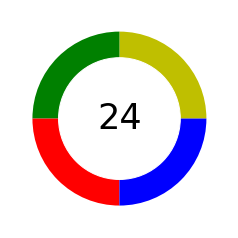

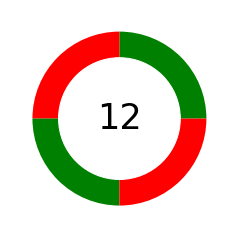

In [130]:
four_col_vizs = four_col_visualize(dfs=dfs, relations=rels, dist_matrix=dist_matrix)

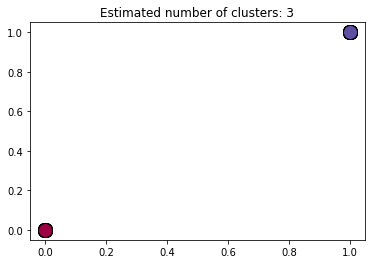

In [131]:
_, labels = dbscan_clustering(dist_matrix=dist_matrix, save_to_file=None)

In [132]:
labels

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 0, 1,
       0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 2,
       1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 2, 1, 0])